In [1]:
%autoreload 2

In [2]:
import logging 
logging.basicConfig()
logging.getLogger("sparklink").setLevel(logging.DEBUG)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf=SparkConf()
conf.set('spark.driver.memory', '8g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show()

+---------+----------+---------+----------+------------+--------------------+-----+
|unique_id|first_name|  surname|       dob|        city|               email|group|
+---------+----------+---------+----------+------------+--------------------+-----+
|        0|    Julia |     null|2015-10-29|      London| hannah88@powers.com|    0|
|        1|    Julia |   Taylor|2015-07-31|      London| hannah88@powers.com|    0|
|        2|    Julia |   Taylor|2016-01-27|      London| hannah88@powers.com|    0|
|        3|    Julia |   Taylor|2015-10-29|        null|  hannah88opowersc@m|    0|
|        4|      oNah|   Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        5|     Noah |   Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        6|    Watson|    Noah |2008-03-23|        null|matthew78@ballard...|    1|
|        7|     Noah |   Watson|2008-02-05|       tolon|matthew78@ballard...|    1|
|        8|    Watson|    Noah |2008-06-15|      Bolton|matthew78@ballard...

In [12]:
blocking_rules = [
    'l.first_name = r.first_name  and  l.surname = r.surname',
    'l.first_name = r.first_name  and  l.surname = r.surname',
    
    'l.first_name = r.first_name  and  l.dob = r.dob',
    'l.first_name = r.first_name  and  l.city = r.city',
    'l.dob = r.dob  and  l.city = r.city'
]

In [13]:
from sparklink.blocking import block_using_rules
df_comparison = block_using_rules(df, blocking_rules, spark=spark)
df_comparison.show()
# df_comparison = cartestian_block(df, df.columns, spark=spark)

INFO:sparklink.blocking:
SELECT l.unique_id AS unique_id_l,
       r.unique_id AS unique_id_r,
       l.first_name AS first_name_l,
       r.first_name AS first_name_r,
       l.surname AS surname_l,
       r.surname AS surname_r,
       l.dob AS dob_l,
       r.dob AS dob_r,
       l.city AS city_l,
       r.city AS city_r,
       l.email AS email_l,
       r.email AS email_r,
       l.group AS group_l,
       r.group AS group_r
FROM df AS l
LEFT JOIN df AS r ON l.first_name = r.first_name
AND l.surname = r.surname
WHERE l.unique_id < r.unique_id
UNION ALL
SELECT l.unique_id AS unique_id_l,
       r.unique_id AS unique_id_r,
       l.first_name AS first_name_l,
       r.first_name AS first_name_r,
       l.surname AS surname_l,
       r.surname AS surname_r,
       l.dob AS dob_l,
       r.dob AS dob_r,
       l.city AS city_l,
       r.city AS city_r,
       l.email AS email_l,
       r.email AS email_r,
       l.group AS group_l,
       r.group AS group_r
FROM df AS l
LEFT JOIN df A

+-----------+-----------+------------+------------+---------+---------+----------+----------+---------------+---------------+--------------------+--------------------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|         city_l|         city_r|             email_l|             email_r|group_l|group_r|
+-----------+-----------+------------+------------+---------+---------+----------+----------+---------------+---------------+--------------------+--------------------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|           null|          Bolno|matthew78@ballard...|matthea78@bwllar-...|      1|      1|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|           null|         London|hesterkurt@taylor...|hesterkurt@taylor...|      9|      9|
|         40|         42|     Olivia |     Olivia |  Andrews|  Andrews|2009-03-2

In [17]:
from sparklink.gammas import add_gammas

gamma_settings = {
    "first_name": {
        "levels": 3,
    },
    "surname": {
        "levels": 3
    },
    "dob": {
        "levels": 2
    },
    "city": {
        "levels": 2
    },
    "email": {
        "levels": 2
    }
}



df_gammas = add_gammas(df_comparison, gamma_settings, spark, include_orig_cols = True)
df_gammas.show()


INFO:sparklink.gammas:
SELECT unique_id_l,
       unique_id_r,
       first_name_l,
       first_name_r,
       surname_l,
       surname_r,
       dob_l,
       dob_r,
       city_l,
       city_r,
       email_l,
       email_r,
       CASE
           WHEN first_name_l IS NULL
                OR first_name_r IS NULL THEN -1
           WHEN first_name_l = first_name_r THEN 2
           WHEN levenshtein(first_name_l, first_name_r)/((length(first_name_l) + length(first_name_r))/2) <= 0.3 THEN 1
           ELSE 0
       END AS gamma_0,
       CASE
           WHEN surname_l IS NULL
                OR surname_r IS NULL THEN -1
           WHEN surname_l = surname_r THEN 2
           WHEN levenshtein(surname_l, surname_r)/((length(surname_l) + length(surname_r))/2) <= 0.3 THEN 1
           ELSE 0
       END AS gamma_1,
       CASE
           WHEN dob_l IS NULL
                OR dob_r IS NULL THEN -1
           WHEN dob_l = dob_r THEN 1
           ELSE 0
       END AS gamma_2,
       CASE
  

+-----------+-----------+------------+------------+---------+---------+----------+----------+---------------+---------------+--------------------+--------------------+-------+-------+-------+-------+-------+
|unique_id_l|unique_id_r|first_name_l|first_name_r|surname_l|surname_r|     dob_l|     dob_r|         city_l|         city_r|             email_l|             email_r|gamma_0|gamma_1|gamma_2|gamma_3|gamma_4|
+-----------+-----------+------------+------------+---------+---------+----------+----------+---------------+---------------+--------------------+--------------------+-------+-------+-------+-------+-------+
|          6|         11|      Watson|      Watson|    Noah |    Noah |2008-03-23|2008-01-21|           null|          Bolno|matthew78@ballard...|matthea78@bwllar-...|      2|      2|      0|     -1|      0|
|         38|         41|     Olivia |     Olivia |  Andrews|  Andrews|2009-01-23|2009-01-23|           null|         London|hesterkurt@taylor...|hesterkurt@taylor...| 

In [24]:
from sparklink.params import Params 
params = Params(gamma_settings, starting_lambda=0.5)

In [25]:
params

λ (proportion of matches) = 0.5
------------------------------------
gamma_0: Comparison of first_name

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.100000 (level represents highest category of string similarity)
------------------------------------
gamma_1: Comparison of surname

Probability distribution of gamma values amongst matches:
    value 0: 0.100000 (level represents lowest category of string similarity)
    value 1: 0.200000 
    value 2: 0.700000 (level represents highest category of string similarity)

Probability distribution of gamma values amongst non-matches:
    value 0: 0.700000 (level represents lowes

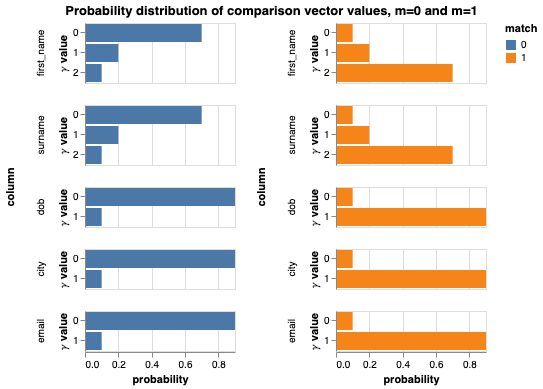

In [26]:
params.probability_distribution_chart()

In [27]:
from sparklink.iterate import iterate
df_e = iterate(df_gammas, spark, params, num_iterations=3)

DEBUG:sparklink.expectation_step:-- We use case statements for these lookups rather than joins for performance and simplicity

SELECT *,
       CASE
           WHEN gamma_0 = -1 THEN 1
           WHEN gamma_0 = 0 THEN 0.7
           WHEN gamma_0 = 1 THEN 0.2
           WHEN gamma_0 = 2 THEN 0.1
       END AS prob_gamma_0_non_match,
       CASE
           WHEN gamma_0 = -1 THEN 1
           WHEN gamma_0 = 0 THEN 0.1
           WHEN gamma_0 = 1 THEN 0.2
           WHEN gamma_0 = 2 THEN 0.7
       END AS prob_gamma_0_match,
       CASE
           WHEN gamma_1 = -1 THEN 1
           WHEN gamma_1 = 0 THEN 0.7
           WHEN gamma_1 = 1 THEN 0.2
           WHEN gamma_1 = 2 THEN 0.1
       END AS prob_gamma_1_non_match,
       CASE
           WHEN gamma_1 = -1 THEN 1
           WHEN gamma_1 = 0 THEN 0.1
           WHEN gamma_1 = 1 THEN 0.2
           WHEN gamma_1 = 2 THEN 0.7
       END AS prob_gamma_1_match,
       CASE
           WHEN gamma_2 = -1 THEN 1
           WHEN gamma_2 = 0 THEN 0.

In [32]:
dfpd = df_e.toPandas()

In [42]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
dfpd.sample(10)[["match_probability"] + list(dfpd.columns)]

,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability
1161,0.812300,473,474,Henry,Henry,Ali,Ali,2012-11-30,2013-02-12,Newcastle-upon-Tyne,Newcaetle-upo-Tyns,None,laura1o@nelon.c2m,2,2,0,0,-1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.5074800252914429,0.20798799395561218,0.13366299867630005,0.1701200008392334,1.00000000000000000,1.00000000000000000,0.812300
767,0.975794,69,72,Isabella,Isabella,Coepo,Cooper,1987-11-18,1987-11-18,Stockton-Tn-oee,Stockton-on-Tees,imoore@turner-gonzalez.info,imoore@turner-gonzalez.info,2,0,1,0,1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.975794
892,0.765192,792,796,Aisha,King,King,Aisha,1980-04-24,1980-04-24,Telford,Telford,None,berrylarry@gonzales.biz,0,0,1,1,-1,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.765192
863,0.999541,539,541,Fredie,Freddie,Roberts,Roberts,2004-11-15,2004-11-15,Bolton,Bolton,browndonald@mccormick.info,browndonald@mccormick.info,1,2,1,1,1,0.004861999768763781,0.06453300267457962,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.999541
486,0.994877,669,672,Ivy,Ivy,Taylor,Taylor,1980-01-13,1980-01-13,Lodno,noLdo,jonesjennifer@pitts.com,jonesjennifer@pitts.com,2,2,1,0,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.994877
1535,0.971517,714,715,Hughes,None,Arthur,Hughes,1998-08-24,1998-08-24,Sheffield,Sheffield,eileenlopez@mcmahon-long.info,eileenlopez@mcmahon-long.info,-1,0,1,1,1,1.000000000000000000,1.00000000000000000,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.971517
241,0.993185,363,364,Nancy,Nancy,Taylor,Taylor,1989-07-25,1989-07-25,London,London,wagnershane@landry.com,wagnershane@landry.com,2,2,1,1,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.993185
978,0.930264,942,944,Oscar,Oscar,James,James,1985-03-26,1985-03-26,Yro,None,None,carlos74@byrd.com,2,2,1,-1,-1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.4925200045108795,0.79201197624206540,1.00000000000000000,1.0000000000000000,1.00000000000000000,1.00000000000000000,0.930264
1049,1.000000,71,78,Isabella,Isabell,Cooper,Coopr,1987-11-18,1987-11-18,Stockton-on-Tees,Stockton-on-Tees,imoore@turner-gonzalez.info,imoore@turner-gonzalez.info,1,1,1,1,1,0.004861999768763781,0.06453300267457962,0.0173530001193285,0.07856699824333191,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,1.000000
180,0.877502,384,386,Lewis,Abigail,Abigail,None,2017-02-05,2017-02-05,Reading,Reading,None,james08@hernandez.info,0,-1,1,1,-1,0.247991994023323060,0.27030000090599060,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.877502


In [45]:
from sparklink.term_frequencies import make_adjustment_for_term_frequencies
df_e_adj = make_adjustment_for_term_frequencies(df_e, params, ["first_name", "surname"], retain_adjustment_columns=True, spark=spark)

In [49]:
pdtf = df_e_adj.toPandas()
pdtf.sample(10)[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r,gamma_0,gamma_1,gamma_2,gamma_3,gamma_4,prob_gamma_0_non_match,prob_gamma_0_match,prob_gamma_1_non_match,prob_gamma_1_match,prob_gamma_2_non_match,prob_gamma_2_match,prob_gamma_3_non_match,prob_gamma_3_match,prob_gamma_4_non_match,prob_gamma_4_match,match_probability,first_name_adj,surname_adj,tf_adjusted_match_prob
923,0.986838,0.986836,978,985,None,None,Ball,None,1992-04-02,1992-04-02,Newcastle-upon-Tyne,Newcastle-upon-Tyne,stacykelly@brown.info,stacykelly@brown.info,-1,-1,1,1,1,1.000000000000000000,1.00000000000000000,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.986838,0.500000,0.500000,0.986836
1272,0.988843,0.999561,967,968,Isla,Isla,None,Beattie,2008-05-07,2008-05-07,Bolton,Btlon,susanmoreno@edwards-wallace.com,susanmoreno@edwards-wallace.com,2,-1,1,0,1,0.747147023677825900,0.66516697406768800,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.988843,0.962548,0.500000,0.999561
714,0.975794,0.968941,306,310,Isabelle,Isabelle,Born,Brown,1979-01-22,1979-01-22,Stte-on-Trenk,Stoke-on-Trent,josephwatson@smith.com,josephwatson@smith.com,2,0,1,0,1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.13366299867630005,0.1701200008392334,0.06494899839162827,0.74093997478485110,0.975794,0.436267,0.500000,0.968941
1406,0.973814,0.973812,950,953,Ameia,Johnson,Johnson,Amelia,1985-05-04,1985-05-04,Luton,Luton,olsondanielle@martinez.com,olsondanielle@martinez.com,0,0,1,1,1,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.973814,0.500000,0.500000,0.973812
1387,0.973778,0.983035,817,820,George,George,Hill,Hill,1984-05-07,1984-03-16,Northampton,Northampton,smithmelinda@christensen-harvey.com,smithmelinda@christensen-harvey.com,2,2,0,1,1,0.747147023677825900,0.66516697406768800,0.2743709981441498,0.59921497106552120,0.5074800252914429,0.20798799395561218,0.86633700132370000,0.8298799991607666,0.06494899839162827,0.74093997478485110,0.973778,0.446187,0.659505,0.983035
142,0.474468,0.474468,523,526,Brown,Martha,Martha,Brown,2002-09-01,2002-09-01,Southend-on-Sea,Southend-on-Sea,watsonthomas@jones-stuart.biz,watsonthomas@jones-s.urttbiz,0,0,1,1,0,0.247991994023323060,0.27030000090599060,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.93505102396011350,0.25905999541282654,0.474468,0.500000,0.500000,0.474468
1093,0.726907,0.625929,804,809,Darcy,Darcy,Webtsr,Webster,1984-02-07,1984-02-07,Colchester,Colchester,katherine96@kim-martinez.com,None,2,0,1,1,-1,0.747147023677825900,0.66516697406768800,0.7082759737968445,0.32221800088882446,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,1.00000000000000000,1.00000000000000000,0.726907,0.385992,0.500000,0.625929
1683,0.960302,0.960300,291,295,Arlo,Arl,Morgan,None,2015-05-15,2015-05-15,Aberdeen,Aberdeen,charles81@elion.bsz,charles81@nelson.biz,1,-1,1,1,0,0.004861999768763781,0.06453300267457962,1.0000000000000000,1.00000000000000000,0.4925200045108795,0.79201197624206540,0.86633700132370000,0.8298799991607666,0.93505102396011350,0.25905999541282654,0.960302,0.500000,0.500000,0.960300
676,0.944481,0.939050,229,236,Charlotte,Charlotte,None,Coper,1995-06-15,1995-06-17,Sunderland,Sunderland,toddsean@wilkins-burton.biz,toddsean@wilkins-burton.biz,2,-1,0,1,1,0.747147023677825900,0.66516697406768800,1.0000000000000000,1.00000000000000000,0.5074800252914429,0.20798799395561218,0.86633700132370000,0.8298799991607666,0.064948998391628

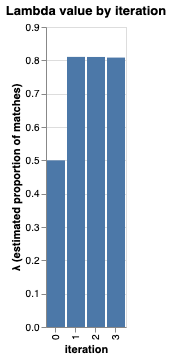

In [29]:
params.lambda_iteration_chart()

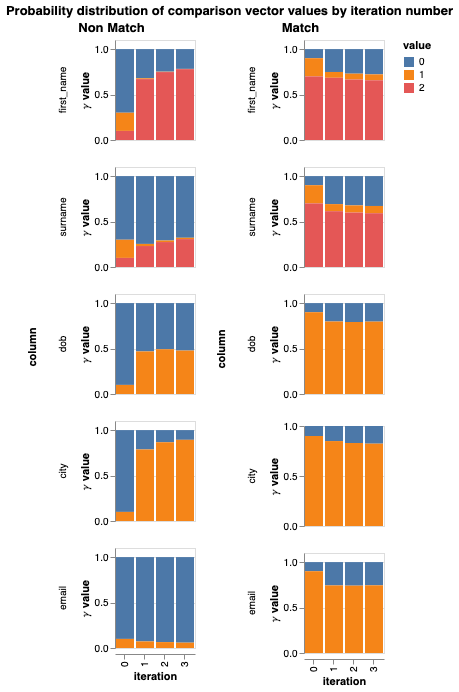

In [30]:
params.pi_iteration_chart()